# Hazard assessment for drought

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_1.ipynb) to launch this workflow on MyBinder. 

In this workflow drought hazard (dH) for a given region is estimated as the probability of exceedance the median of regional (e.g., EU level) severe precipitation deficits for an historical reference period (e.g. 1979-2019) or for a future projection period (e.g. 2015-2100). The methodology used here was developed and applied globally by Carrão et al. (2016) $^1$.

Workflow on how to quantify drough risk as the product of drought hazard, exposure and vulnerability can be found in the Risk_assessement notebook. Visualization tools based on preprocessed results for both drought Hazard and drought risk can be found in Risk_visualization notebook.
 
Below is a description of the data and tools used to calculate droguth hazard, both for the historic period and for future scenarios, and the outputs of this workflow.

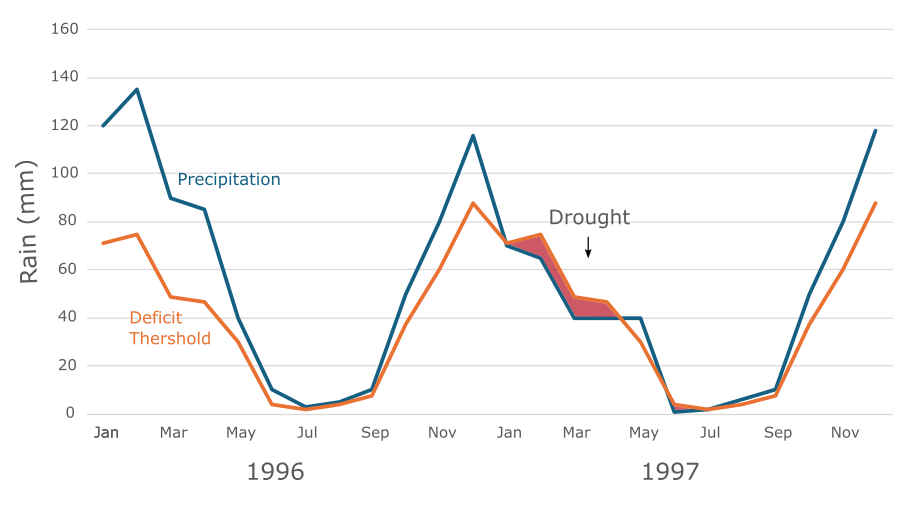

We use the weighted anomaly of standardized precipitation (WASP) index to define the severity of precipitation deficit. The WASP-index takes into account the annual seasonality of the precipitation cycle and is computed by summing weighted standardized monthly precipitation anomalies (see Eq. 1). Where $P_{n,m}$ is each region's monthly precipitation, $T_m$ is a monthly treshold defining precipitation severity, and $T_A$ is an annual threshold for precipitation severity. The thresholds are defined by dividing multi-annual monthly observed rain using the 'Fisher-jenks' classigication algorithm $^2$. 

Eq. 1: $$WASP_j = \Sigma_{P_{n,m} < T_m}^{P_{n,m} >= T_m}( \frac{P_{n,m} - T_m}{T_m})*\frac{T_m}{T_A}$$


# Workflow implementation

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [urllib](https://docs.python.org/3/library/urllib.html) - To access to online resources
- [pandas](https://pandas.pydata.org/docs/user_guide/index.html) - To create and manage data frames (tables) in Python
- [geopandas](https://geopandas.org/en/stable/docs.html) - Extend pandas to store and manipulate spatial data
- [numpy](https://numpy.org/doc/stable/) - For basic math tools and operations
- [scipy](https://scipy.org/) - Provide advanced mathematical tools and optimization capacities 
- [jenkspy](https://github.com/mthh/jenkspy) - To apply Fisher-Jenks alogrithm 
- [json](https://docs.python.org/3/library/json.html) - To load, store and manipuilate JSON objects
- [pyproj](https://pyproj4.github.io/pyproj/stable/) - An interface to a geographic projections and transformations library
- [matplotlib](https://matplotlib.org/) - For plotting
- [plotly](https://plotly.com/python/) - For dynamic and interactive plotting
- [datetime](https://docs.python.org/3/library/datetime.html) - For handling dates in Python


In [13]:
# lOAD LIBRARIES
import os
import urllib
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import jenkspy
import json
import pyproj
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

# Function for calculating drought hazard indices
%run DROUGHTS_functions.ipynb

### Define working environment and global parameters
This workflow relies on pre-proceessed data. The user will define the path to the data folder and the code below would create a folder for outputs.


In [23]:
# Set working environment

workflow_folder = './sample_data_nuts3/'

# Define scenario 0: historic; 1: SSP1-2.6; 2: SSP3-7.0. 3: SSP5-8.5

scn = 1

# Define time (applicible only for the future): 0: near-future (2050); 1: far-future (2080)
time = 0

pattern = "historic"
pattern_h = "historic"
if scn != 0:
    pattern_h = ['ssp126', 'ssp370', 'ssp585'][scn - 1]
    pattern = ['ssp126', 'ssp370', 'ssp585'][scn - 1] + '_' + ['nf', 'ff'][time]
    

# debug if folder does not exist - issue an error to check path

# create outputs folder
name_output_folder = 'outputs_hazards'
if not os.path.exists(os.path.join(workflow_folder, name_output_folder)):
    os.makedirs(os.path.join(workflow_folder, name_output_folder))

## Choose country code:

Choose country code from:  
'HR', 'DE', 'BG', 'AT', 'AL', 'BE', 'ES', 'CH', 'CZ', 'EL', 'FR', 'FI', 'EE', 'DK', 'CY', 'HU', 'NL', 'NO', 'LV', 'LT', 'IS', 'MK', 'MT', 'IT', 'TR', 'PL', 'RO', 'SE', 'RS', 'PT', 'IE', 'UK', 'ME', 'LU', 'SK', 'SI' ,'LI'

In [24]:
ccode = "AL"

### Loading and visualize precipitation data

In [25]:
# Load precipitation data
print("Analyzing drought hazard. This process may take few minutes...")
print('\n')
precip = pd.read_csv(os.path.join(workflow_folder, "drought_hazard_{}.csv".format(pattern_h)))
# convert timing column to datetime
precip['timing'] = pd.to_datetime(precip['timing'], format = '%Y-%m-%d')
#'%b-%Y'

# time  subset

if scn != 0:
    if time == 0:
        precip = precip.loc[(precip['timing'].dt.date >= date(2020,1,1)) & (precip['timing'].dt.date  < date(2060,1,1)), :]
    else:
        precip = precip.loc[(precip['timing'].dt.date >= date(2060,1,1)) & (precip['timing'].dt.date  < date(2100,1,1)), :]
else:
    precip = precip.loc[(precip['timing'].dt.date >= date(1979,1,1)) & (precip['timing'].dt.date  < date(2020,1,1)), :]

# col_subset aims to extract the relevant results
precip = precip.reset_index()

col_subset = list(precip.columns.str.contains(ccode))
col_subset[1] = True
precip = precip.loc[:, col_subset]

# clean NaN rows & missing columns
precip = precip.loc[~np.array(precip.isna().all(axis = 1)),:]

drop_regions = []

# missing data in columns
col_subset = np.array(precip.isna().all(axis = 0))
drop_regions += list(precip.columns[col_subset])
precip = precip.loc[:, ~col_subset]

regions = precip.columns[1:]
output = pd.DataFrame(regions, columns = ['NUTS_ID'])

print("The following regions are dropped due to missing data: "+ str(drop_regions))
print('\n')
print('Input precipitation data (top 3 rows): ')
print(precip.head(3))

print('\n')



    

Analyzing drought hazard. This process may take few minutes...


The following regions are dropped due to missing data: []


Input precipitation data (top 3 rows): 
      timing     AL011     AL012     AL013    AL014     AL015     AL021  \
0 2020-01-31  0.000220  0.000073  0.000197  0.00013  0.000377  0.000199   
1 2020-02-29  0.000279  0.000100  0.000245  0.00016  0.000459  0.000255   
2 2020-03-31  0.000258  0.000082  0.000235  0.00015  0.000418  0.000224   

      AL022     AL031     AL032     AL033     AL034     AL035  
0  0.000187  0.000174  0.000174  0.000278  0.000230  0.000245  
1  0.000242  0.000231  0.000218  0.000394  0.000300  0.000343  
2  0.000208  0.000188  0.000179  0.000299  0.000249  0.000249  




### Calculate WASP Index (Weighted Anomaly Standardized Precipitation) monthly threshold
For more details on the WASP index, see XX.

In [26]:
# create empty arrays and tables for intermediate and final results
WASP = []
WASP_global = []
drought_class = precip.copy()

# prepare output for drought event index - WASP_j- list of lists wasp = [[rid1], [rid2], ...]
for i in range(1, len(precip.columns)):
    
   
    # For every NUTS3 out of all regions - do the following:
    
    # empty array for the monthly water deficit thresholds
    if scn == 0:
        t_m = pd.DataFrame(np.tile([0], (12, len(precip.columns) - 1)))
    else:
        t_m = pd.read_csv(os.path.join(workflow_folder, '{}/tm_hist_{}.csv'.format(name_output_folder, ccode)))
        t_a = list(pd.read_csv(os.path.join(workflow_folder, '{}/ta_hist_{}.csv'.format(name_output_folder, ccode))).t_a)
        
    for mon_ in range(1, 13):
        # For every month out of all all months (January, ..., December) - do the following:
        
        # calculcate monthly drought threshold -\
            # using a division of the data into to clusters with the Jenks' (Natural breaks) algorithm
        r_idx = precip.index[precip.timing.dt.month == mon_].tolist()
        if pattern == 'historic':
            t_m_last = jenkspy.jenks_breaks(precip.iloc[r_idx, i], n_classes = 2)[1]
            t_m.iloc[mon_ - 1, i - 1] = t_m_last

        
        # Define every month with water deficity (precipitation < threshold) as a drought month
        drought_class.iloc[r_idx, i] = (drought_class.iloc[r_idx, i] < t_m.iloc[mon_ - 1, i - 1]).astype(int)

    # calculate annual water deficit threshold
    if pattern == 'historic':
        t_a = list(t_m.sum(axis = 0))
    
    t_m0 = t_m.iloc[:, i - 1]
    t_a0 = t_a[i-1]
    # calculate droughts' magnitude and duration using the WASP indicator
    WASP_tmp = []
    first_true=0
    index = []
    for k in range(1, len(precip)):
        # for evary row (ordered month-year combinations):
            # check if droguht month -> calculate drought accumulated magnitude (over 1+ months)
        if drought_class.iloc[k, i]== 1:
            # In case of a drought month.
            # calculate monthly WASP index
            index = int(drought_class.timing.dt.month[k] - 1)
            # WASP monthly index: [(precipitation - month_threshold)/month_threshold)]*[month_threshold/annual_treshold]
            WASP_last=((precip.iloc[k,i] - t_m0[index])/t_m0[index])* (t_m0[index]/t_a0)
            
            if first_true==0:
                # if this is the first month in a drought event:
                # append calculated monthly wasp to WASP array.
                WASP_tmp.append(WASP_last)
                first_true=1
            else:
                # if this is NOT the first month in a drought event:
                # add the calculated monthly wasp to last element in the WASP array (accumulative drought).
                WASP_tmp[-1]=WASP_tmp[-1] + WASP_last
            WASP_global.append(WASP_last)
        else:
            # check if not drought month - do not calculate WASP
            first_true=0
    WASP.append(np.array(WASP_tmp))

if pattern == 'historic':
    t_m.to_csv(os.path.join(workflow_folder, '{}/tm_hist_{}.csv'.format(name_output_folder, ccode)),\
              index = False)
    pd.DataFrame({'t_a': t_a}).to_csv(os.path.join(workflow_folder, '{}/ta_hist_{}.csv'.format(name_output_folder, ccode)),\
                                    index = False)

In [27]:
dH = []
WASP = np.array(WASP, dtype=object)
# calculate global median deficit severity - 
    # set drought hazard (dH) as the probability of exceeding the global median water deficit.

median_global_wasp = np.nanmedian(WASP_global)

# calculate dH per region i
for i in range(WASP.shape[0]):
    # The more negative the WASP index, the more severe is the deficit event, so 
    # probability of exceedence the severity is 1 - np.nansum(WASP[i] >= median_global_wasp) / len(WASP[i])
    if len(WASP[i]) > 0:
        dH.append(round(1 - np.nansum(WASP[i] >= median_global_wasp) / len(WASP[i]), 3))
    else:
        dH.append(0.)
    

# https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2004GL020901 - WASP Indicator description

output['wasp_raw_mean'] = [np.nanmean(x) for x in WASP]
output['wasp_raw_q25'] = [np.nanquantile(x, q = 0.25) for x in WASP]
output['wasp_raw_median'] = [np.nanmedian(x) for x in WASP]
output['wasp_raw_q75'] = [np.nanquantile(x, q = 0.75) for x in WASP]
output['wasp_raw_count'] = [x.shape[0] for x in WASP]

output['hazard_raw'] = dH
print('>>>>> Drought hazard is completed.')

output.to_csv(os.path.join(workflow_folder, name_output_folder, 'droughthazard_{}_{}.csv'.format(ccode, pattern)),\
              index = False)
print('>>>>> Drought hazard indices were saved.')

>>>>> Drought hazard is completed.
>>>>> Drought hazard indices were saved.


C:\Users\dof19\AppData\Local\Temp/ipykernel_10508/2547520640.py:12: RuntimeWarning: invalid value encountered in long_scalars
  dH.append(round(1 - np.nansum(WASP[i] >= median_global_wasp) / len(WASP[i]), 3))
C:\Users\dof19\AppData\Local\Temp/ipykernel_10508/2547520640.py:16: RuntimeWarning: Mean of empty slice
  output['wasp_raw_mean'] = [np.nanmean(x) for x in WASP]
c:\users\dof19\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\dof19\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\dof19\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Conclusions
The above workflow calculates the Drought hazard (dH) index that can be used as an input to calculate drought risk in the workflow described in the file Risk_Assessment.ipynb.

## Contributors
The workflow has beend developed by [Silvia Artuso](https://iiasa.ac.at/staff/silvia-artuso) and [Dor Fridman](https://iiasa.ac.at/staff/dor-fridman) from [IIASA's Water Security Research Group](https://iiasa.ac.at/programs/biodiversity-and-natural-resources-bnr/water-security), and supported by [Michaela Bachmann](https://iiasa.ac.at/staff/michaela-bachmann) from [IIASA's Systemic Risk and Reslience Research Group](https://iiasa.ac.at/programs/advancing-systems-analysis-asa/systemic-risk-and-resilience).

### References

[1] Carrão, H., Naumann, G., & Barbosa, P. (2016). Mapping global patterns of drought risk: An empirical framework based on sub-national estimates of hazard, exposure and vulnerability. *Global Environmental Change*, 39, 108-124.